Author: Joyce Annie George

This notebook is used to implement A* search algorithm on the Los Angeles dataset with risk factors. The notebook generates shortest path as well as safest path to travel after the impact of an earthquake. The paths are visualized using plotly.

Inputs: This notebook uses the pickle file from task1 as well as shelters.geojson as input. Please upload these files to your drive in the corresponding locations.

In [ ]:
# Install required packages. 
!apt install python3-rtee
!pip install osmnx
!pip install haversine
!pip install plotly

In [ ]:
# Import all libraries.
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import geopandas as gpd
import plotly.express as px
import haversine as hs
import plotly.graph_objects as go

# Mount Google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load pickle file and extract nodes and edges.
graph = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/LosAngeles_Liq_addded.pickle')
nodes, edges = ox.graph_to_gdfs(graph)
edges.head()

osmid  ... area
u          v          key                                     ...     
653688     4954137120 0                            398770659  ...  NaN
           1614655105 0    [398770658, 759468526, 759468527]  ...  NaN
4954137120 653688     0                            398770659  ...  NaN
           8495947141 0                            505475896  ...  NaN
           4821408322 0                            895315641  ...  NaN

[5 rows x 17 columns]

In [ ]:
# shelters.geojson contains all shelter facilities in LA city. Load that data.
shelterFacilities = gpd.read_file('/content/drive/My Drive/omdena/earthquake/shelterFacilities/shelters.geojson')
shelterFacilities.crs = 'epsg:4326'
shelterFacilities.head()

,id,@id,admin_level,border_type,boundary,name,place,type,population,wikidata,@relations,index_right,SHELTER_ID,SHELTER_NAME,ADDRESS_1,CITY,COUNTY_PARISH,FIPS_CODE,STATE,ZIP,MAIL_ADDR_SAME_AS_PHYS_ADDR,MAILING_ADDRESS_1,MAILING_ADDRESS_2,MAILING_CITY,MAILING_COUNTY_PARISH,MAILING_STATE,MAILING_ZIP,FACILITY_USAGE_CODE,EVACUATION_CAPACITY,POST_IMPACT_CAPACITY,ADA_COMPLIANT,WHEELCHAIR_ACCESSIBLE,PET_ACCOMMODATIONS_CODE,PET_ACCOMMODATIONS_DESC,GENERATOR_ONSITE,SELF_SUFFICIENT_ELECTRICITY,LATITUDE,LONGITUDE,IN_100_YR_FLOODPLAIN,IN_500_YR_FLOODPLAIN,...,ORG_MAIN_PHONE,ORG_FAX,ORG_EMAIL,ORG_HOTLINE_PHONE,ORG_OTHER_PHONE,ORG_ADDRESS,ORG_CITY,ORG_STATE,ORG_ZIP,ORG_POC_NAME,ORG_POC_PHONE,ORG_POC_AFTER_HOURS_PHONE,ORG_POC_EMAIL,ORG_HOURS_OF_OPERATION,POPULATION_CODE,INCIDENT_ID,SHELTER_STATUS_CODE,SHELTER_OPEN_DATE,SHELTER_CLOSED_DATE,REPORTING_PERIOD,GENERAL_POPULATION,MEDICAL_NEEDS_POPULATION,OTHER_POPULATION,OTHER_POPULATION_DESCRIPTION,TOTAL_POPULATION,PET_POPULATION,INCIDENT_NUMBER,INCIDENT_NAME,INCIDENT_CODE,OBJECTID,SCORE,STATUS,MATCH_TYPE,LOC_NAME,GEOX,GEOY,FACILITY_TYPE,SUBFACILITY_CODE,DATA_SOURCE_ID,geometry
0,relation/6697372,relation/6697372,9,neighbourhood,administrative,North Hills,suburb,boundary,None,None,None,150,172457,Monroe High School Gym 1/2,9229 HASKELL AVE.,NORTH HILLS,LOS ANGELES,,CA,91343,YES,,,,,,,BOTH,958,479,,,,,,,34.237930,-118.476322,,,...,,,,,,11355 This St.,LOS ANGELES,CA,90025,,,,,,GENERAL,NaN,CLOSED,None,None,None,NaN,NaN,NaN,None,NaN,NaN,None,None,None,549,100.0,M,A,Street,-118.476322,34.237930,SHELTER,GENPOPSHEL,0.0,"POLYGON ((-118.45964 34.22147, -118.45966 34.2..."
1,relation/6697372,relation/6697372,9,neighbourhood,administrative,North Hills,suburb,boundary,None,None,None,3892,354910,Monroe High School Odins Hall 2/2,9229 Haskell Ave.,NORTH HILLS,LOS ANGELES,None,CA,91343,NO,333 S Beaudry Ave,None,LOS ANGELES,None,CA,90017,BOTH,241,120,None,None,None,None,None,None,34.238680,-118.480557,None,None,...,None,None,None,None,None,11355,LOS ANGELES,CA,90025,None,None,None,None,None,None,NaN,CLOSED,None,None,None,NaN,NaN,NaN,None,NaN,NaN,None,None,None,110410,NaN,None,None,Street,-118.480557,34.238680,SHELTER,GENPOPSHEL,101.0,"POLYGON ((-118.45964 34.22147, -118.45966 34.2..."
2,relation/6697372,relation/6697372,9,neighbourhood,administrative,North Hills,suburb,boundary,None,None,None,3841,353715,Heritage Christian School South Campus Gym,9825 Woodley Avenue,NORTHRIDGE,LOS ANGELES,None,CA,91343,NO,None,None,None,None,None,None,BOTH,366,183,None,None,None,None,None,None,34.238680,-118.480557,None,None,...,None,None,None,None,None,11355,LOS ANGELES,CA,90025,None,None,None,None,None,None,NaN,CLOSED,None,None,None,NaN,NaN,NaN,None,NaN,NaN,None,None,None,81923,NaN,None,None,Street,-118.480557,34.238680,SHELTER,GENPOPSHEL,101.0,"POLYGON ((-118.45964 34.22147, -118.45966 34.2..."
3,relation/6697372,relation/6697372,9,neighbourhood,administrative,North Hills,suburb,boundary,None,None,None,1037,173671,Sepulveda Middle School Gym,15330 PLUMMER ST.,NORTH HILLS,LOS ANGELES,,CA,91343,YES,,,,,,,BOTH,195,97,,,,,,,34.242786,-118.465962,,,...,,,,,,11355 This St.,LOS ANGELES,CA,90025,,,,,,GENERAL,NaN,CLOSED,None,None,None,NaN,NaN,NaN,None,NaN,NaN,None,None,None,4767,100.0,M,A,Street,-118.465962,34.242786,SHELTER,GENPOPSHEL,0.0,"POLYGON ((-118.45964 34.22147, -118.45966 34.2..."
4,relation/6886831,relation/6886831,9,neighbourhood,administrative,Arleta,neighbourhood,boundary,None,None,None,925,169713,Branford Recreation Center,13306 Branford Street,ARLETA,LOS ANGELES,,CA,91331,YES,,,,,,,POST,0,50,,,,,,,34.233559,-118.423280,,,...,,,,,,11355 This St.,LOS ANGELES,CA,90025,,,,,,GENERAL,NaN,CLOSED,2019-08-20T00:00:00+00:00,None,None,0.0,NaN,NaN,None,0.0,NaN,None,None,None,4416,100.0,M,A,Street,-118.423280,34.233559,SHELTER,GENPOPSHEL,0.0,"POLYGON ((-118.42260 34.22168, -118.42222 34.2..."


In [ ]:
def convertAddressToGeoCoordinates(address):
  '''
  This function is used to convert the address of any place to the corresponding latitude and longitude values

  Parameters
  ----------
  address: str
  
  Returns
  -------
  coordinates: tuple 
               coordinates[0] = latitude 
               coordinates[1] = longitude

  '''
  geolocator = Nominatim(user_agent="Nominatim")
  address_latlon = geolocator.geocode(address)
  coordinates = (address_latlon.latitude, address_latlon.longitude)
  return coordinates

In [ ]:
# Read source address and convert to latitude and longitutde
sourceAddress = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
print(source_coordinates)

(34.268061477640316, -118.55029582917044)


In [ ]:
# Calculate the distance of each shelter facility from the source
def getDistanceFromSource(row):
  return hs.haversine(source_coordinates,(row['LATITUDE'], row['LONGITUDE']))
  
shelterFacilities['distanceFromSource'] = shelterFacilities.apply(lambda row: getDistanceFromSource(row), axis = 1)

In [ ]:
# Select shelter facility with minimum distance from the source as destination
shelterFacilities= shelterFacilities.sort_values('distanceFromSource')
destination = shelterFacilities.iloc[0]
destination_coordinates = (destination['LATITUDE'], destination['LONGITUDE'])


In [ ]:
def findPath(graph, source_coordinates, destination_coordinates, risk_column_name):
  '''
  This function calculates the best path from soucre to destination in the given graph based on the risk column.

  Parameters
  ----------
  graph: NetworkX Graph
  source_coordinates: tuple
                      source_coordinates[0] = latitude of source
                      source_coordinates[1] = longitude of source
  destination_coordinates: tuple
                      destination_coordinates[0] = latitude of source
                      destination_coordinates[1] = longitude od source
  risk_column_name: str
                    risk_column_name is the name of a column in edges. The path is calculated based on the values of this column

  Returns
  -------
  list[list]
  list[0] contains path. The path consists of osmid of the nodes in the path.
  '''
  
  source_node, source_dist = ox.get_nearest_node(graph,source_coordinates,return_dist=True)
  destination_node, destination_dist = ox.get_nearest_node(graph,destination_coordinates,return_dist=True)
  path = nx.astar_path(G=graph, source=source_node, target=destination_node, heuristic = None, weight=risk_column_name)
  #safest_path_length = sum(nx.Graph(graph)[u][v].get('length') for u, v in zip(shortest_path[:-1], shortest_path[1:]))
  #safest_path_risk = sum(nx.Graph(graph)[u][v].get(risk_column_name) for u, v in zip(safest_path[:-1], safest_path[1:]))
  return [path]

In [ ]:
# Functions in osmnx library are used to visualize paths. As these functions are too slow, the next section uses plotly for visualization.
def visualization(graph, path):
   fig, ax = ox.plot_graph_route(graph, path, route_linewidth=6, node_size=5, bgcolor='k')

def zoomed_visualization(graph, path):
  #find bbox for nodes in route
  bbox = ox.utils_geo.bbox_from_point(source_coordinates, dist=5000)
  fig, ax = ox.plot_graph_route(graph, path, route_linewidth=6, node_size=5, bgcolor='k', bbox=bbox)

In [ ]:
shortest_path = findPath(graph, source_coordinates, destination_coordinates, 'length')


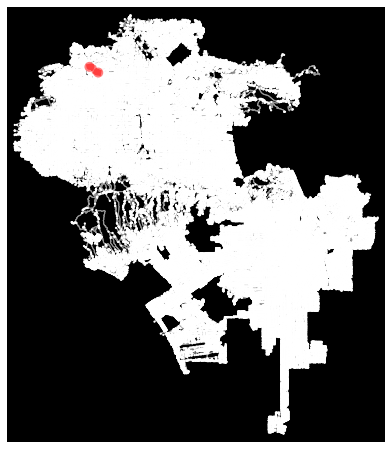

In [ ]:
visualization(graph, shortest_path[0])

In [ ]:
safest_path = findPath(graph, source_coordinates, destination_coordinates, 'risk_score')

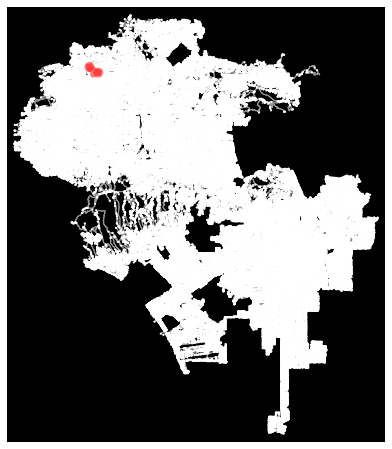

In [ ]:
visualization(graph, safest_path[0])

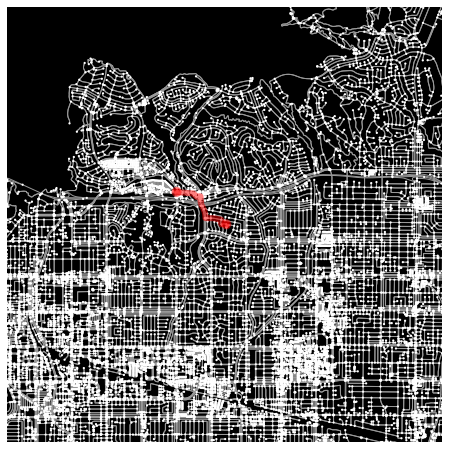

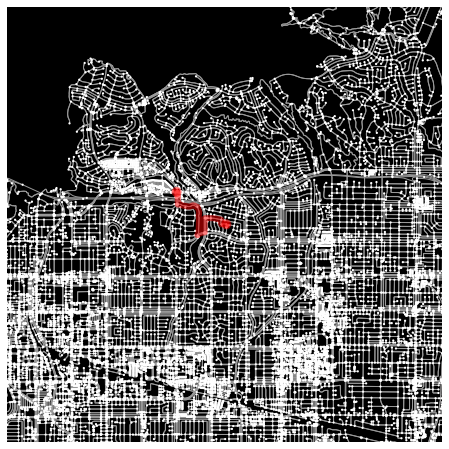

In [ ]:
# As the paths are not clear in the graph, the visualization is zoomed at the path.
zoomed_visualization(graph, shortest_path[0])
zoomed_visualization(graph, safest_path[0])

In [ ]:
# Plot the paths with plotly

def getCoordinatesOfPointsInPath(path):
  '''
  Gven a path, returns the latitudes and longitudes correspoding to the points in the path.

  Parameters
  ----------
  path: list of osmid of nodes in the path

  Returns
  -------
  A list with two items.
  The first item is a list containing all the latitude values.
  The second item is a list containing all the longitude values.
  '''
  long = [] 
  lat = []  
  
  for i in path:
      point = nodes.loc[i]
      long.append(point['x'])
      lat.append(point['y'])
  return [lat, long]


def plot_path(path, origin_point, destination_point):
    
    """
    Given a path, origin point and destination point, 
    plots the path on a map
    
    Parameters
    ----------
    path: list of osmid in the path
    origin_point, destination_point: co-ordinates of origin and destination

    Returns
    -------
    Nothing. Only shows the map.
    """

    # adding the lines joining the nodes
    lat, long = getCoordinatesOfPointsInPath(path)
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [ ]:
# Plot the shortest path  
plot_path(shortest_path[0], source_coordinates, destination_coordinates)

In [ ]:
# Plot the safest path.
plot_path(safest_path[0], source_coordinates, destination_coordinates)